In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
np.set_printoptions(precision=None, suppress=True)

# Load and Split Training Data

In [3]:
# split data into labels and features: the data has 5 locations in it and each feature is like: loc 1, band 1, winter
data = np.load('nparray-data/training-data-final.npy')
labels = data[:, -1]
features = data[:, :-1]
np.unique(labels)
# data.shape

array([  1.,   2.,   3.,   5.,   6.,  22.,  44.,  88., 200.],
      dtype=float32)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test

# np.unique(X_train, return_counts=True)

# Baseline Test Model

In [12]:
rf = RandomForestClassifier(n_estimators=500, max_depth=None)
forest = rf.fit(X_train, y_train)

In [13]:
y_pred = forest.predict(X_test)
np.unique(y_pred)

array([  1.,   2.,   3.,   5.,   6.,  22.,  44.,  88., 200.],
      dtype=float32)

In [11]:
y_pred_probs = forest.predict_proba(X_test)
y_pred_probs

array([[0.03724569, 0.144751  , 0.11766067, ..., 0.06537385, 0.25761048,
        0.00310981],
       [0.00007881, 0.00002686, 0.00002008, ..., 0.42937306, 0.05437946,
        0.00006877],
       [0.12996694, 0.02004413, 0.18398248, ..., 0.06601616, 0.15002272,
        0.01019839],
       ...,
       [0.20193054, 0.17762562, 0.00392508, ..., 0.11857546, 0.17918911,
        0.03164227],
       [0.14040331, 0.07823482, 0.00844012, ..., 0.06605406, 0.2022074 ,
        0.06759769],
       [0.20805942, 0.17874695, 0.0038561 , ..., 0.11919627, 0.17902945,
        0.03046389]])

In [14]:
accuracy = forest.score(X_test, y_test, sample_weight=None)
accuracy

0.7153184536654541

In [15]:
forest.feature_importances_

array([0.02749347, 0.01888087, 0.01750837, 0.01832349, 0.0186802 ,
       0.01807497, 0.01766665, 0.01794528, 0.01883094, 0.02251018,
       0.02372784, 0.02344165, 0.02547623, 0.0242964 , 0.00950106,
       0.0185405 , 0.01762349, 0.01920526, 0.00455719, 0.        ,
       0.        , 0.02073713, 0.01282282, 0.01234302, 0.01404741,
       0.01479723, 0.01345676, 0.01338735, 0.01225546, 0.01271017,
       0.01870724, 0.01377332, 0.01430528, 0.00396689, 0.01234676,
       0.01263263, 0.01108342, 0.01076363, 0.01202567, 0.00648412,
       0.00522331, 0.        , 0.01775295, 0.01239592, 0.01223132,
       0.01283925, 0.01415704, 0.01353015, 0.01311111, 0.01327332,
       0.01383273, 0.01774523, 0.01750565, 0.01675119, 0.01285341,
       0.01959864, 0.00609493, 0.01281786, 0.01270159, 0.01256045,
       0.00135555, 0.        , 0.        , 0.00960452, 0.00654645,
       0.00621537, 0.00664641, 0.00756861, 0.00779218, 0.00722162,
       0.00690261, 0.00709098, 0.00890597, 0.00810235, 0.00808

# Model w/ Feature Selection and Parameter Tuning 

## Running Model With Feature Selection

In [5]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 500, max_depth=None, class_weight='balanced', random_state=42))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(class_weight='balanced',
                                                 n_estimators=500,
                                                 random_state=42))

In [6]:
selected_feat = pd.DataFrame(X_train).columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

46
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
            21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 38, 42, 45,
            47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 75, 76],
           dtype='int64')


In [18]:
sel.threshold_

0.011904761904761908

In [7]:
# Transform the training data set to only have selected features
X_training_selected = sel.transform(X_train)
X_testing_selected = sel.transform(X_test)
# Count of features whose importance value is greater than the threshold value
importantFeaturesCount = X_training_selected.shape[1]
importantFeaturesCount

46

In [20]:
fs_rfmodel = RandomForestClassifier(n_estimators=500, max_depth=None, class_weight='balanced')
fs_rfmodel.fit(X_training_selected, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500)

In [21]:
y_preds_featsel = fs_rfmodel.predict(X_testing_selected)

In [11]:
# feature selected model cfmatrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def generate_confmatrix(y_true, y_pred, location):        
    matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    class_names = ['Corn', 'Cash Crop', 'Rice', 'Soybeans', 'Other Major Crop', 'Wheat',  'Other Crop',  'Non-Crop', 'Double Crop']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.title('Confusion Matrix for Random Forest Model With Feature Selection, Location {}'.format(str(location)))
    plt.savefig('confmatrix-46feats-loc-{}'.format(str(location)))
    plt.show()

    return 'confmatrix saved'

In [12]:
# feature selected model classification report
def generate_classification_rep(y_true, y_pred, location):
    rep = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    rep = pd.DataFrame(rep).transpose()
    rep['bucket_label'] = ['Corn', 'Cash Crop', 'Rice', 'Soybeans', 'Other Major Crop', 'Wheat',  'Other Crop',  'Non-Crop', 'Double Crop'] + ['accuracy', 'macro avg', 'weighted avg']
    rep.set_index('bucket_label', inplace=True)
    rep.index.name = None
    display(rep)
    rep.to_csv('report-46feats-loc-{}.csv'.format(str(location)))
    return 'report saved'

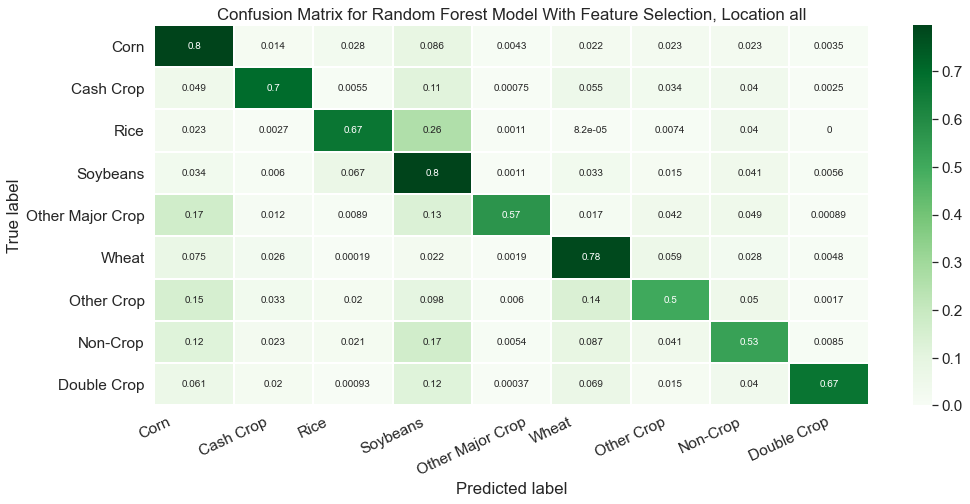

'confmatrix saved'

In [24]:
generate_confmatrix(y_test, y_preds_featsel, 'all')

In [25]:
generate_classification_rep(y_test, y_preds_featsel, 'all')

precision    recall  f1-score        support
Corn               0.705972  0.796168  0.748362   38517.000000
Cash Crop          0.663239  0.699635  0.680951    9312.000000
Rice               0.624799  0.667486  0.645437   12207.000000
Soybeans           0.646519  0.797586  0.714151   38436.000000
Other Major Crop   0.759127  0.567824  0.649686    3369.000000
Wheat              0.729914  0.784222  0.756094   31880.000000
Other Crop         0.720301  0.502037  0.591682   26510.000000
Non-Crop           0.722152  0.528161  0.610107   29029.000000
Double Crop        0.815082  0.672504  0.736960    5368.000000
accuracy           0.694402  0.694402  0.694402       0.694402
macro avg          0.709678  0.668403  0.681492  194628.000000
weighted avg       0.699311  0.694402  0.689207  194628.000000

'report saved'

## Parameter Tuning


In [26]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform

rf = RandomForestClassifier(random_state=42)

# Parameters to try

# Grid Search
# params = {
    #"n_estimators":[250],
    #"max_depth":[25, 100, None],
    #"class_weight": ['balanced']
#}

params = {"max_depth": [50, 100, 250, 500, None],
          "n_estimators": range(250, 750),
          "class_weight": ['balanced']}

In [27]:
# HalvingRandomSearchCV (cross-validation) implementation on rf model
search_cv = HalvingRandomSearchCV(rf, params, cv=5, scoring='f1_weighted', verbose=10, factor=10) # validating params by weighted f1 score
search_cv.fit(X_training_selected, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 90
max_resources_: 778512
aggressive_elimination: False
factor: 10
----------
iter: 0
n_candidates: 2500
n_resources: 90
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


/Users/karina/Desktop/Projects/research-2021/.research-2021/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 2500 is smaller than n_iter=8650. Running 2500 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5; 1/2500] START class_weight=balanced, max_depth=50, n_estimators=250....
[CV 1/5; 1/2500] END class_weight=balanced, max_depth=50, n_estimators=250;, score=(train=1.000, test=0.160) total time=   1.3s
[CV 2/5; 1/2500] START class_weight=balanced, max_depth=50, n_estimators=250....
[CV 2/5; 1/2500] END class_weight=balanced, max_depth=50, n_estimators=250;, score=(train=1.000, test=0.426) total time=   0.6s
[CV 3/5; 1/2500] START class_weight=balanced, max_depth=50, n_estimators=250....
[CV 3/5; 1/2500] END class_weight=balanced, max_depth=50, n_estimators=250;, score=(train=1.000, test=0.451) total time=   0.5s
[CV 4/5; 1/2500] START class_weight=balanced, max_depth=50, n_estimators=250....
[CV 4/5; 1/2500] END class_weight=balanced, max_depth=50, n_estimators=250;, score=(train=1.000, test=0.270) total time=   0.5s
[CV 5/5; 1/2500] START class_weight=balanced, max_depth=50, n_estimators=250....
[CV 5/5; 1/2500] END class_weight=balanced, max_depth=50, n_estimators=250;, score=

HalvingRandomSearchCV(estimator=RandomForestClassifier(random_state=42),
                      factor=10,
                      param_distributions={'class_weight': ['balanced'],
                                           'max_depth': [50, 100, 250, 500,
                                                         None],
                                           'n_estimators': range(250, 750)},
                      refit=<function _refit_callable at 0x149999310>,
                      scoring='f1_weighted', verbose=10)

In [28]:
search_cv.best_params_  

{'n_estimators': 505, 'max_depth': 500, 'class_weight': 'balanced'}

In [29]:
# Get the best set of parameters from the list
def get_best_params(results):
    print(f'Best parameters are: {results.best_params_}')
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
    return results.best_params_

In [31]:
get_best_params(search_cv)

Best parameters are: {'n_estimators': 505, 'max_depth': 500, 'class_weight': 'balanced'}
0.295 + or -0.123 for the {'n_estimators': 250, 'max_depth': 50, 'class_weight': 'balanced'}
0.304 + or -0.115 for the {'n_estimators': 251, 'max_depth': 50, 'class_weight': 'balanced'}
0.304 + or -0.115 for the {'n_estimators': 252, 'max_depth': 50, 'class_weight': 'balanced'}
0.304 + or -0.115 for the {'n_estimators': 253, 'max_depth': 50, 'class_weight': 'balanced'}
0.304 + or -0.115 for the {'n_estimators': 254, 'max_depth': 50, 'class_weight': 'balanced'}
0.304 + or -0.115 for the {'n_estimators': 255, 'max_depth': 50, 'class_weight': 'balanced'}
0.304 + or -0.115 for the {'n_estimators': 256, 'max_depth': 50, 'class_weight': 'balanced'}
0.304 + or -0.115 for the {'n_estimators': 257, 'max_depth': 50, 'class_weight': 'balanced'}
0.304 + or -0.115 for the {'n_estimators': 258, 'max_depth': 50, 'class_weight': 'balanced'}
0.304 + or -0.115 for the {'n_estimators': 259, 'max_depth': 50, 'class_we

{'n_estimators': 505, 'max_depth': 500, 'class_weight': 'balanced'}

## Running Model With Parameter Tuning (tuning only for now)

In [46]:
# CV results
num_trees = 671
depth = 50

rf_optimized = RandomForestClassifier(n_estimators=num_trees, max_depth=depth, class_weight='balanced')
rf_optimized.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=50, n_estimators=671)

In [47]:
y_preds = rf_optimized.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
accuracy_score(y_test, y_preds)

0.7455967281172288

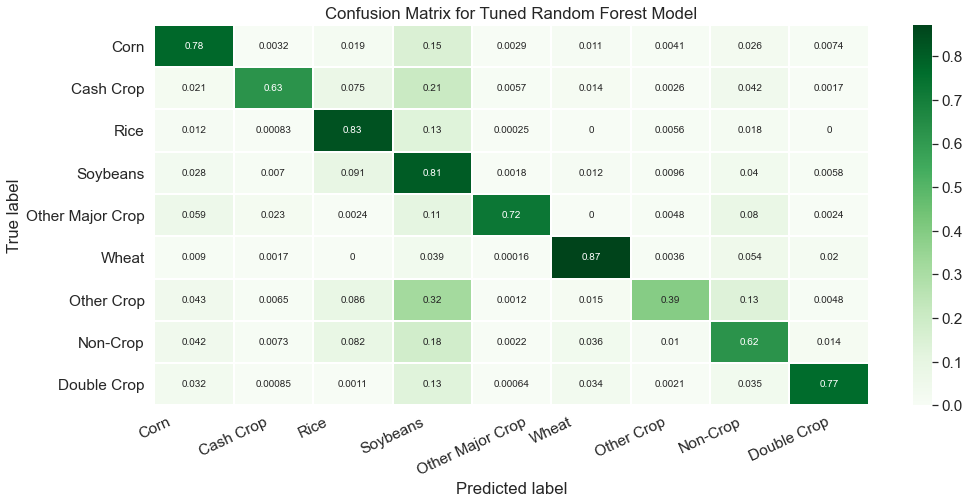

In [49]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Corn', 'Cash Crop', 'Rice', 'Soybeans', 'Other Major Crop', 'Wheat',  'Other Crop',  'Non-Crop', 'Double Crop']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Tuned Random Forest Model')
plt.show()

In [50]:
import pandas as pd
rep = classification_report(y_test, y_preds, zero_division=0, output_dict=True)
rep = pd.DataFrame(rep).transpose()
rep['bucket_label'] = ['Corn', 'Cash Crop', 'Rice', 'Soybeans', 'Other Major Crop', 'Wheat',  'Other Crop',  'Non-Crop', 'Double Crop'] + ['accuracy', 'macro avg', 'weighted avg']
rep.set_index('bucket_label', inplace=True)
rep.index.name = None
rep.to_csv('report-84features-postrandomcvtuning.csv')

In [51]:
rep

precision    recall  f1-score       support
Corn               0.822153  0.775089  0.797928  14010.000000
Cash Crop          0.819273  0.625895  0.709646   3491.000000
Rice               0.648924  0.831485  0.728948  12082.000000
Soybeans           0.726300  0.806025  0.764089  33525.000000
Other Major Crop   0.780488  0.722090  0.750154    842.000000
Wheat              0.792627  0.871714  0.830291   6314.000000
Other Crop         0.752212  0.392761  0.516064   5194.000000
Non-Crop           0.762584  0.623274  0.685927  17161.000000
Double Crop        0.838071  0.766134  0.800490   4695.000000
accuracy           0.745597  0.745597  0.745597      0.745597
macro avg          0.771404  0.712719  0.731504  97314.000000
weighted avg       0.751775  0.745597  0.741554  97314.000000

In [30]:
rep = pd.read_csv('saved_results/report-84features-difftimesimgs-1.csv')
rep.set_index('Unnamed: 0', inplace=True)
rep.index.name = None
rep

precision    recall  f1-score       support
Corn               0.821089  0.777016  0.798445  14010.000000
Cash Crop          0.813884  0.621312  0.704678   3491.000000
Rice               0.649442  0.833223  0.729942  12082.000000
Soybeans           0.727226  0.805101  0.764185  33525.000000
Other Major Crop   0.775223  0.720903  0.747077    842.000000
Wheat              0.790339  0.868071  0.827383   6314.000000
Other Crop         0.755972  0.396034  0.519773   5194.000000
Non-Crop           0.759840  0.620943  0.683405  17161.000000
Double Crop        0.835343  0.767199  0.799822   4695.000000
accuracy           0.745175  0.745175  0.745175      0.745175
macro avg          0.769818  0.712200  0.730523  97314.000000
weighted avg       0.751203  0.745175  0.741113  97314.000000

## Running Model with Tuning and Selected Features

In [8]:
# CV results
num_trees = 505
depth = 500

rf_optimized_featsel = RandomForestClassifier(n_estimators=num_trees, max_depth=depth, class_weight='balanced')
rf_optimized_featsel.fit(X_training_selected, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=500, n_estimators=505)

In [9]:
y_preds_featsel = rf_optimized_featsel.predict(X_testing_selected)

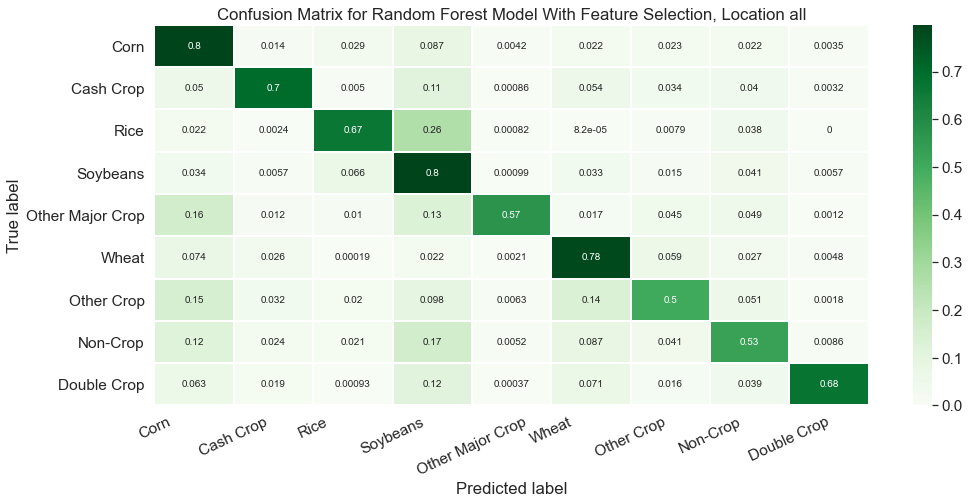

'confmatrix saved'

In [14]:
generate_confmatrix(y_test, y_preds_featsel, 'all')

In [ ]:
# feature selected model classification report
import pandas as pd
rep = classification_report(y_test, y_preds_featsel, zero_division=0, output_dict=True)
rep = pd.DataFrame(rep).transpose()
rep['bucket_label'] = ['Corn', 'Cash Crop', 'Rice', 'Soybeans', 'Other Major Crop', 'Wheat',  'Other Crop',  'Non-Crop', 'Double Crop'] + ['accuracy', 'macro avg', 'weighted avg']
rep.set_index('bucket_label', inplace=True)
rep.index.name = None
rep.to_csv('report-selectedfeatures-loc-all-newdata.csv')
rep

precision    recall  f1-score       support
Corn               0.784569  0.722912  0.752480  14010.000000
Cash Crop          0.512790  0.625895  0.563725   3491.000000
Rice               0.612473  0.786045  0.688488  12082.000000
Soybeans           0.698759  0.762267  0.729132  33525.000000
Other Major Crop   0.778061  0.724466  0.750308    842.000000
Wheat              0.790987  0.867279  0.827378   6314.000000
Other Crop         0.729592  0.357913  0.480238   5194.000000
Non-Crop           0.756456  0.602529  0.670775  17161.000000
Double Crop        0.836311  0.737806  0.783976   4695.000000
accuracy           0.710216  0.710216  0.710216      0.710216
macro avg          0.722222  0.687457  0.694056  97314.000000
weighted avg       0.718855  0.710216  0.707142  97314.000000

In [10]:
from sklearn.model_selection import cross_validate
raw_features_selected = sel.transform(features)
cv_ = cross_validate(rf_optimized_featsel, raw_features_selected, labels, scoring='f1_weighted', verbose=10000)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[CV] END ......................................., score=0.314 total time=39.6min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 39.6min remaining:    0.0s
[CV] START .....................................................................
[CV] END ......................................., score=0.317 total time=35.6min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 76.8min remaining:    0.0s
[CV] START .....................................................................
[CV] END ......................................., score=0.267 total time=39.3min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 116.2min remaining:    0.0s
[CV] START .....................................................................
[CV] END ......................................, score=0.284 total time=143.3min
[Parallel(n_jobs=1)]: Done   4

In [17]:
cv_

{'fit_time': array([2333.85571504, 2075.71543479, 2307.77853513, 8354.89596128,
        7850.83308601]),
 'score_time': array([ 40.35485077,  57.43175101,  49.91077995, 245.03960705,
         37.88391781]),
 'test_score': array([0.3141549 , 0.31659224, 0.26703483, 0.28443445, 0.24253822])}

In [ ]:
from sklearn.model_selection import cross_validate
#raw_features_selected = sel.transform(features)
cv_2 = cross_validate(rf_optimized_featsel, X_training_selected, y_train, scoring='f1_weighted', verbose=10000)

In [ ]:
cv_2

In [80]:
from sklearn.metrics import f1_score

train_preds = rf_optimized_featsel.predict(X_training_selected)
train_f1_weighted = f1_score(y_train, train_preds, average='weighted')
train_f1_macro = f1_score(y_train, train_preds, average='macro')

print(train_f1_weighted, train_f1_macro) # 0.946959782132445 and 0.9453411190514568

0.9469597821324445 0.9453411190514568


In [81]:
test_preds = rf_optimized_featsel.predict(X_testing_selected)
test_f1_weighted = f1_score(y_test, test_preds, average='weighted')
test_f1_macro = f1_score(y_test, test_preds, average='macro')
print(test_f1_weighted, test_f1_macro) # 0.7068676614202919 and 0.692908127980919

0.7068676614202919 0.692908127980919


# Getting F1 Scores By Location

In [ ]:
from sklearn.model_selection import train_test_split

f1scores = {
    'weightedf1': [],
    'macrof1': []
}

for rs in range(0, 10):
    X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, test_size=0.2, random_state=rs)
    print(y_test1, y_test1.size)
    print('Beginning iteration {}'.format(str(rs)))
    
    rfc = RandomForestClassifier(n_estimators=671, max_depth=50, class_weight='balanced')
  
    X_train1_selected = sel.transform(X_train1)
    X_test1_selected = sel.transform(X_test1)
    print('features selected')

    rfc.fit(X_train1_selected, y_train1)
    print('model fitted')

    y_test1_preds = rfc.predict(X_test1_selected)
    print('predictions generated')

    f1_weighted = f1_score(y_test1, y_test1_preds, average='weighted')
    f1_macro = f1_score(y_test1, y_test1_preds, average='macro')
    
    f1scores['weightedf1'].append(f1_weighted)
    f1scores['macrof1'].append(f1_macro)

    print(f1scores)
    print('Completed iteration ', rs)


# outputs so far: 
# 'weightedf1': [0.7064492324655531, 0.7073329706891069, 0.7059730902227124, 0.7057491972665428], 
# 'macrof1': [0.6926272940875158, 0.6944827423020131, 0.6919855076524686, 0.6938984034868292]
print(f1scores)

In [113]:
f1scores_byloc = {}

def get_f1scores_byloc(loc_num: int):
    loc_feats_train = np.delete(features, [range(97314*i, 97314*(i+1))], 0)
    loc_labels_train = np.delete(labels, [range(97314*i, 97314*(i+1))], 0)

    loc_feats_test = features[97314*i:97314*(i+1)]
    loc_labels_test = labels[97314*i:97314*(i+1)]
     
    print(loc_labels_train.shape, loc_labels_test.shape)

    loc_train_selected = sel.transform(loc_feats_train)
    loc_test_selected = sel.transform(loc_feats_test)

    print('features selected')

    rfc1 = RandomForestClassifier(n_estimators=671, max_depth=50, class_weight='balanced')
    rfc1.fit(loc_train_selected, loc_labels_train)
    print('model fitted')

    loc_test1_preds = rfc.predict(loc_test_selected)
    print('predictions generated')

    f1_weighted = f1_score(loc_labels_test, loc_test1_preds, average='weighted')
    f1_macro = f1_score(loc_labels_test, loc_test1_preds, average='macro')
    
    f1scores_byloc['Location ' + str(i+1)] = [f1_weighted, f1_macro]
    print(generate_confmatrix(loc_labels_test, loc_test1_preds, i))
    print(generate_classification_rep(loc_labels_test, loc_test1_preds, i))

    return 'iteration completed'

(389256,) (97314,)
features selected
model fitted
predictions generated
confmatrix saved
report saved
{'Location 2': [0.9687234845705361, 0.9776363248211791]}
Completed location  2
(389256,) (97314,)
features selected
model fitted
predictions generated
confmatrix saved
report saved
{'Location 2': [0.9687234845705361, 0.9776363248211791], 'Location 3': [0.9423661095490052, 0.9506111100916781]}
Completed location  3
(389256,) (97314,)
features selected
model fitted
predictions generated
confmatrix saved
report saved
{'Location 2': [0.9687234845705361, 0.9776363248211791], 'Location 3': [0.9423661095490052, 0.9506111100916781], 'Location 4': [0.9263858774638559, 0.920694968571314]}
Completed location  4
(389256,) (97314,)
features selected
model fitted
predictions generated
confmatrix saved
report saved
{'Location 2': [0.9687234845705361, 0.9776363248211791], 'Location 3': [0.9423661095490052, 0.9506111100916781], 'Location 4': [0.9263858774638559, 0.920694968571314], 'Location 5': [0.931

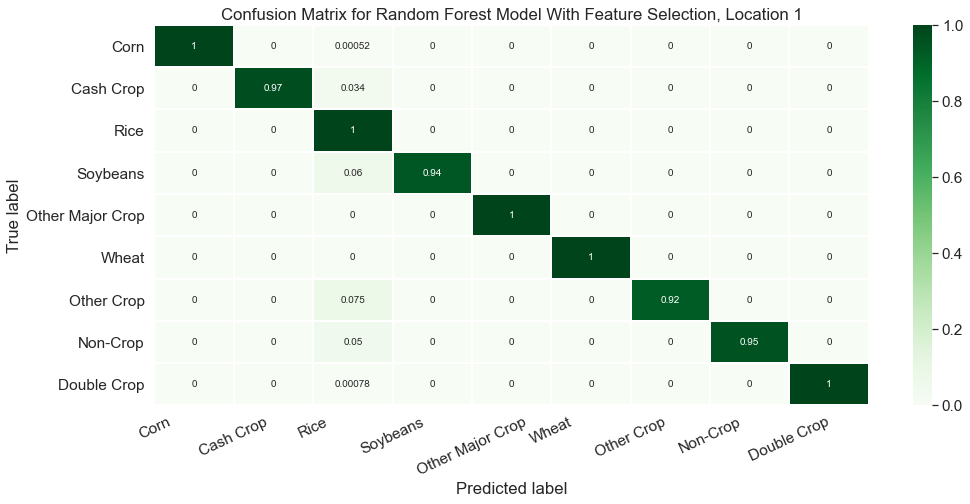

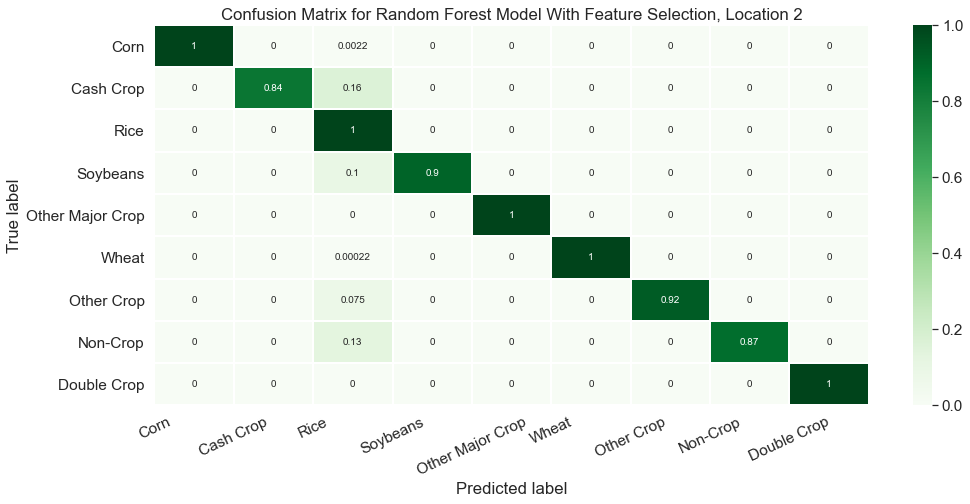

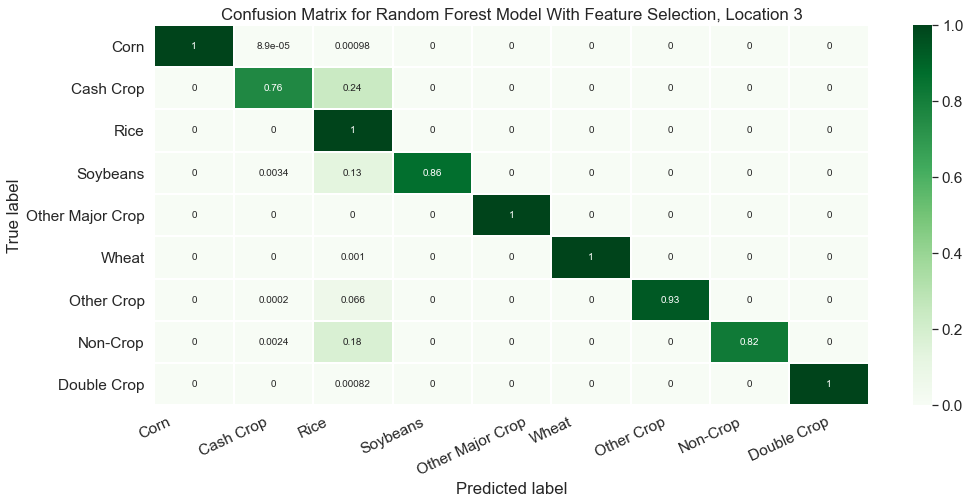

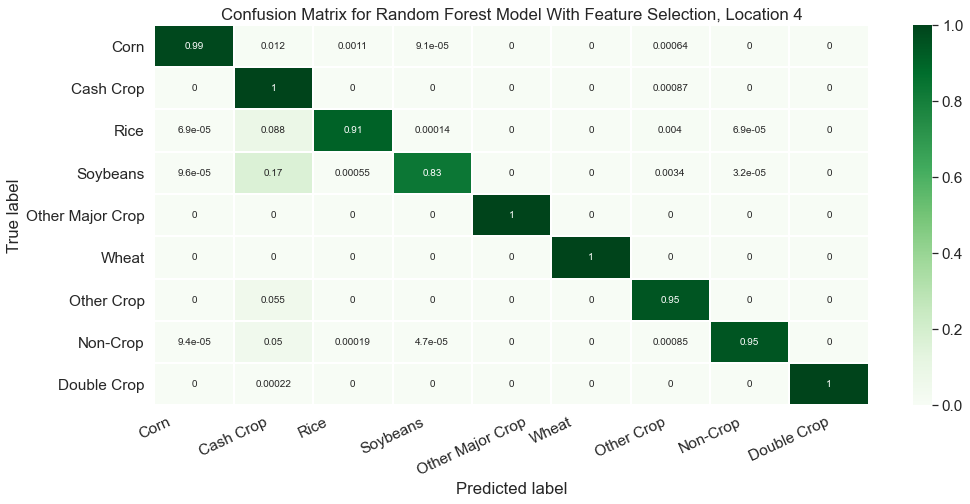

In [114]:
for i in range(1, 5):
    get_f1scores_byloc(i)
    print(f1scores_byloc)
    print('Completed location ', i+1)

# loc1: f1 with parameter tuning (weighted, macro): [0.32576657872322806, 0.21491785029077004]
# loc2: [0.9687234845705361, 0.9776363248211791]
# loc3: [0.9423661095490052, 0.9506111100916781]
# loc4: [0.9263858774638559, 0.920694968571314]
# loc5: [0.931574409469934, 0.9235531719574881]

In [ ]:
f1scores_byloc

# Model Testing By Location

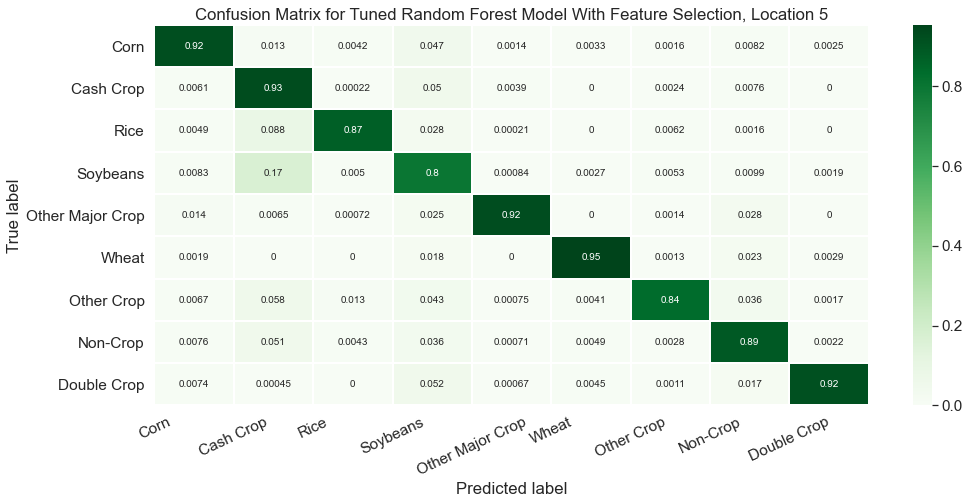

In [76]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

matrix = confusion_matrix(loc5_labels, y_preds_loc5)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Corn', 'Cash Crop', 'Rice', 'Soybeans', 'Other Major Crop', 'Wheat',  'Other Crop',  'Non-Crop', 'Double Crop']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Tuned Random Forest Model With Feature Selection, Location 5')
plt.show()

In [78]:
# feature selected model classification report
import pandas as pd
rep = classification_report(loc1_labels, y_preds_loc1, zero_division=0, output_dict=True)
rep = pd.DataFrame(rep).transpose()
rep['bucket_label'] = ['Corn', 'Cash Crop', 'Rice', 'Soybeans', 'Other Major Crop', 'Wheat',  'Other Crop',  'Non-Crop', 'Double Crop'] + ['accuracy', 'macro avg', 'weighted avg']
rep.set_index('bucket_label', inplace=True)
rep.index.name = None
rep.to_csv('report-51feats-loc1.csv')
rep

precision    recall  f1-score       support
Corn               0.961285  0.943622  0.952372  10341.000000
Cash Crop          0.974666  0.927411  0.950451   3692.000000
Rice               0.821405  0.964490  0.887215  10138.000000
Soybeans           0.938556  0.945919  0.942223  34541.000000
Other Major Crop   1.000000  1.000000  1.000000      2.000000
Wheat              0.956340  0.972735  0.964468   6125.000000
Other Crop         0.971694  0.840852  0.901551   7226.000000
Non-Crop           0.961999  0.931185  0.946341  21042.000000
Double Crop        0.975741  0.946518  0.960907   4207.000000
accuracy           0.937635  0.937635  0.937635      0.937635
macro avg          0.951298  0.941415  0.945059  97314.000000
weighted avg       0.940394  0.937635  0.937962  97314.000000

# Creating Image Renderings

In [115]:
## Generating Raster from location 2array
import rasterio as rio
from rasterio.plot import reshape_as_raster
    
loc_feats_train = np.delete(features, [range(97314, 97314*2)], 0)
loc_labels_train = np.delete(labels, [range(97314, 97314*2)], 0)

# image for each location 
loc2 = features[97314:97314*(2)]
loc2_labels = labels[97314:97314*(2)]

loc2_train_sel = sel.transform(loc_feats_train)
loc2_selected = sel.transform(loc2)

# generate predictions for location 1
rfc_fordisplay = RandomForestClassifier(n_estimators=671, max_depth=50, class_weight='balanced')
rfc_fordisplay.fit(loc2_train_sel, loc_labels_train)

RandomForestClassifier(class_weight='balanced', max_depth=50, n_estimators=671)

In [116]:
y_preds_loc2 = rfc_fordisplay.predict(loc2_selected)

confmatrix saved


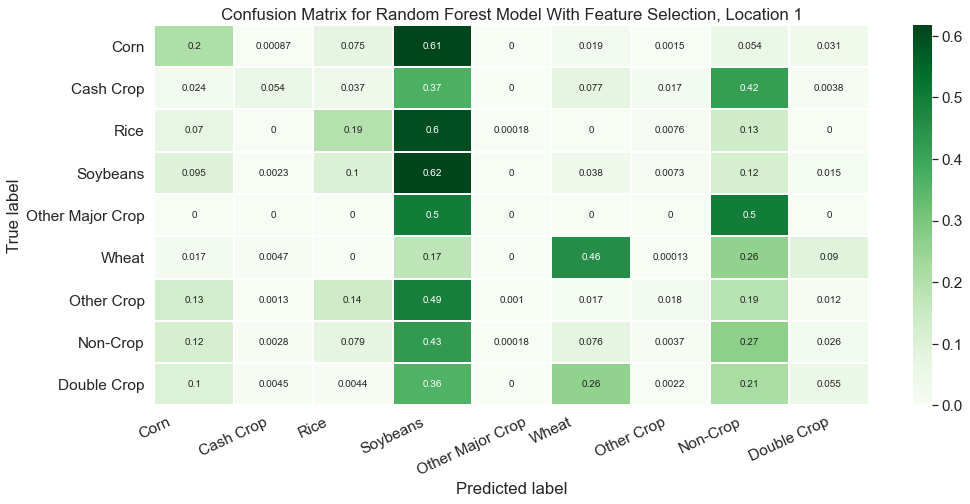

In [129]:
print(generate_confmatrix(loc2_labels, y_preds_loc2, 1))

In [123]:
ground_loc2_array = loc_labels_test.reshape(294, 331, 1)
ground_loc2_array = reshape_as_raster(ground_loc2_array)

predicted_loc2_array = y_preds_loc2.reshape(294, 331, 1)
predicted_loc2_array = reshape_as_raster(predicted_loc2_array)
print(predicted_loc2_array.shape)
np.unique(ground_loc2_array, return_counts=True)

(1, 294, 331)


(array([  1.,   2.,   3.,   5.,   6.,  22.,  44.,  88., 200.],
       dtype=float32),
 array([10341,  3692, 10138, 34541,     2,  6125,  7226, 21042,  4207]))

In [125]:
from rasterio.enums import Resampling

with rio.open('data/ee/cdl_imgs/cdl_location2.tif') as src:
    profile = src.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
   
    profile.update(
        #dtype=rio.uint8,
        count=1,
        height=294,
        width=331,
        compress='png')
    
with rio.open('predicted_location2_img.tif', 'w', **profile) as dst:
    dst.write(predicted_loc2_array)

<AxesSubplot:>

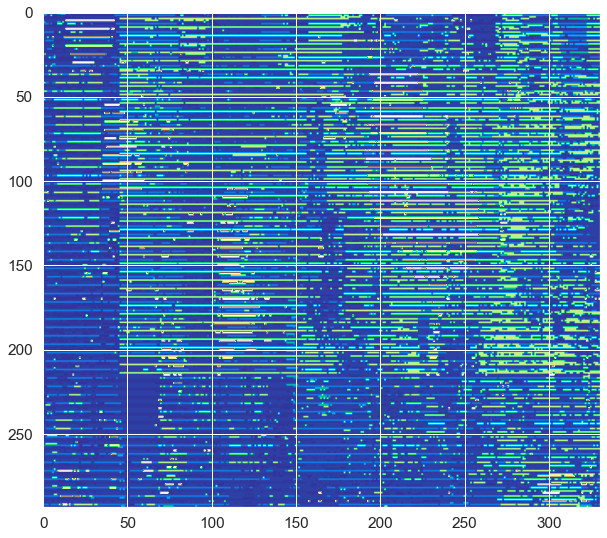

In [126]:
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_image

loc2_img = rio.open('predicted_location2_img.tif').read()
loc2_cdl = rio.open('data/ee/cdl_imgs/cdl_location2.tif').read()

fig, ax = plt.subplots(figsize=(10, 10))
show(loc2_img, ax=ax, cmap='terrain')

<AxesSubplot:>

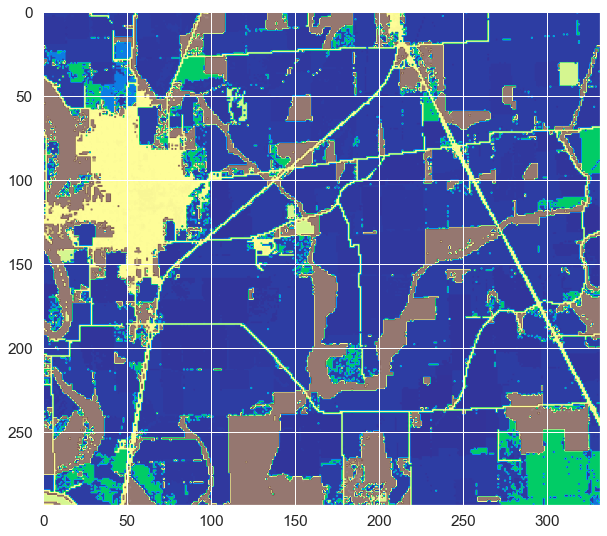

In [127]:
fig, ax = plt.subplots(figsize=(10, 10))
show(loc2_cdl, ax=ax, cmap='terrain')